In [1]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA

# Instantiate the Template class
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Cleaned_Resumen_datos_completos_Rev_final.xlsx')
# import the data from all sheets of the Excel file


df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]

df_concatenation = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], ignore_index=True)

In [2]:
RefDf = df0[(df0['Tratamiento'] == 'Control')]

# Extract the relevant columns (from column 2 onwards)
data_cols = RefDf.iloc[:, 2:]

# The reference value is the mean of RefDf for each wavelength
REF = data_cols.mean()

REF.head()

350    0.062436
351    0.062431
352    0.059371
353    0.060901
354    0.062268
dtype: float64

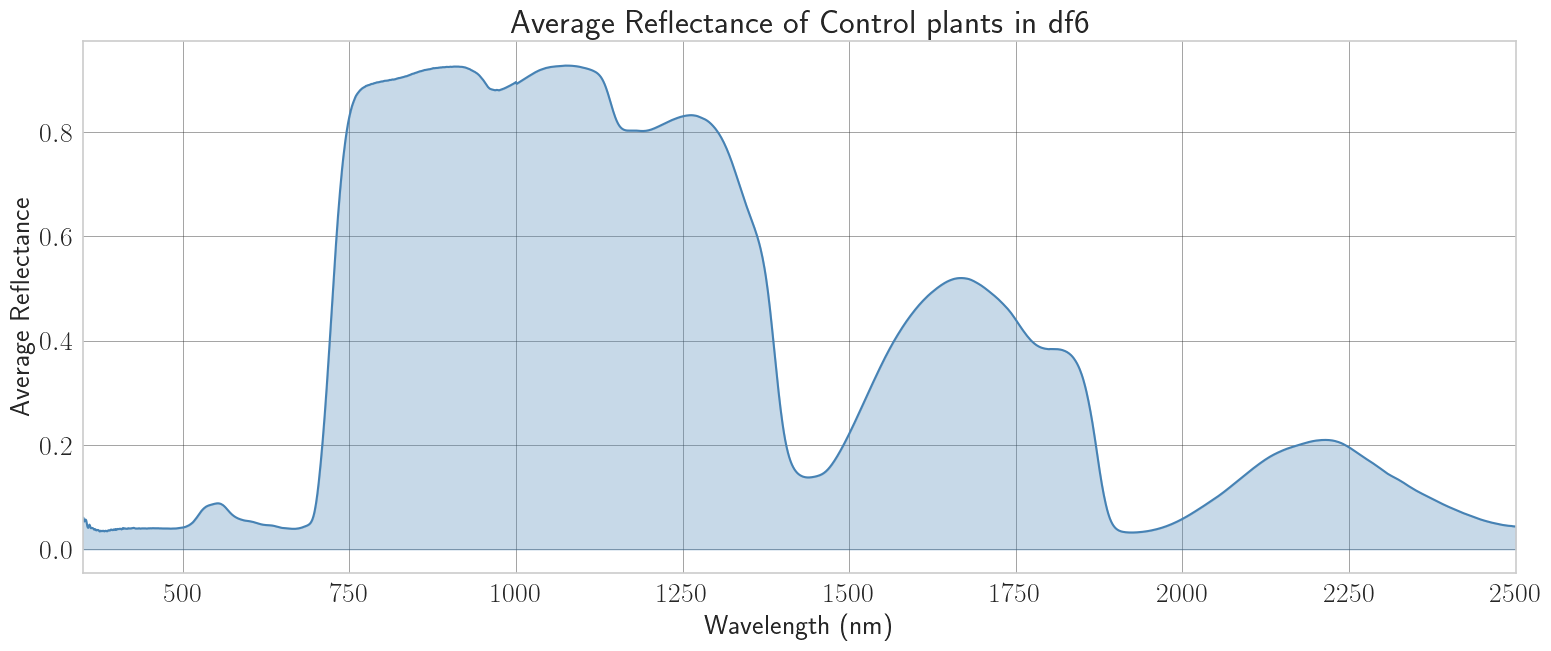

In [3]:
wavelengths = RefDf.columns[2:].astype(float)
magnitudes_values = RefDf.iloc[0, 2:].values.astype(float)
 
# Plot 1: Line plot of magnitudes across wavelengths
plt.figure(figsize=(16, 7))
plt.plot(wavelengths, magnitudes_values, linewidth=1.5, color='steelblue')
plt.fill_between(wavelengths, magnitudes_values, alpha=0.3, color='steelblue')
plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Average Reflectance', fontsize=20)
plt.title('Average Reflectance of Control plants in df6', fontsize=24, fontweight='bold')
plt.grid(True, alpha=0.5)
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

## Cambio relativo respecto a la referencia

In [4]:
all_magnitudes = []

for treatment in df_concatenation['Tratamiento'].unique():
    df_treat = df_concatenation[df_concatenation['Tratamiento'] == treatment]
    for plant_num in df_treat['Planta'].unique():
        df_plant = df_treat[df_treat['Planta'] == plant_num]
        
        # Extract the relevant columns (from column 2 onwards)
        data_cols = df_plant.iloc[:, 2:]

        # Calculate the magnitude for each column
        magnitudes = []

        for col in data_cols.columns:
            # Get the column values
            values = data_cols[col].values
            
            # Get the reference value from REF for this wavelength
            REF_value = REF[col]
            
            # Calculate |y-REF|/REF, |z-REF|/REF, etc. for all values
            if REF_value != 0:  # Avoid division by zero
                differences = np.abs(values - REF_value) / REF_value
                # Calculate the magnitude (Euclidean norm)
                magnitude = np.sqrt(np.sum(differences**2))
            else:
                magnitude = np.nan  # Handle zero reference value
            
            magnitudes.append(magnitude)

        # Create a row with treatment and plant info plus magnitudes
        row_data = {'Tratamiento': treatment, 'Planta': plant_num}
        row_data.update({col: mag for col, mag in zip(data_cols.columns, magnitudes)})
        
        all_magnitudes.append(row_data)

# Create the final dataframe with all magnitudes
df_all_magnitudes = pd.DataFrame(all_magnitudes)

# Display the result
print(f"Final shape: {df_all_magnitudes.shape}")
print(f"Treatments: {df_all_magnitudes['Tratamiento'].unique()}")
print(f"Number of plants: {len(df_all_magnitudes)}")
df_all_magnitudes.tail()

Final shape: (120, 2153)
Treatments: ['Control' 'Ralstonia' 'E_Hidrico' 'Ral_EH']
Number of plants: 120


,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
115,Ral_EH,26.0,0.772444,0.850897,0.609939,0.638301,0.707864,0.689115,0.647704,0.605091,...,10.421963,10.450626,10.477879,10.507628,10.538655,10.567677,10.598226,10.625321,10.648635,10.675046
116,Ral_EH,27.0,0.799202,0.822740,0.645034,0.686606,0.769335,0.772269,0.702456,0.530928,...,0.472415,0.473886,0.475175,0.476880,0.480303,0.482380,0.482663,0.485741,0.490890,0.492905
117,Ral_EH,28.0,0.729295,0.751608,0.665554,0.623428,0.654049,0.648703,0.557492,0.453612,...,0.773413,0.776789,0.785198,0.788111,0.788894,0.789068,0.785067,0.785646,0.787594,0.790490
118,Ral_EH,29.0,1.016040,1.016035,0.893219,0.909945,0.942728,0.933077,0.909902,0.760497,...,15.628802,15.667741,15.699117,15.737804,15.780869,15.818587,15.858153,15.893453,15.920465,15.959097
119,Ral_EH,30.0,0.519393,0.530716,0.427624,0.401532,0.463696,0.489042,0.422169,0.351966,...,0.890715,0.892239,0.891910,0.893195,0.895485,0.896910,0.898797,0.899322,0.898529,0.899484


# Cambio Promedio Relativo Respecto a Planta de Referencia


In [6]:
df_means = df_all_magnitudes.groupby('Tratamiento').mean()

df_means.head()

,Planta,350,351,352,353,354,355,356,357,358,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
Tratamiento,,,,,,,,,,,,,,,,,,,,,
Control,15.5,0.933505,0.811687,1.097585,0.871509,0.671317,0.655399,0.711838,0.930916,1.062917,...,0.880165,0.884297,0.888986,0.892717,0.895425,0.898654,0.901701,0.904648,0.907779,0.910176
E_Hidrico,15.5,0.492707,0.409069,0.646761,0.460207,0.371486,0.403891,0.386544,0.525356,0.656963,...,0.760446,0.763490,0.767368,0.770061,0.771964,0.774038,0.775354,0.777498,0.780198,0.782042
Ral_EH,15.5,0.890850,0.902408,0.824552,0.779374,0.824776,0.849177,0.757854,0.683107,0.666764,...,11.806675,11.838748,11.864491,11.897002,11.932963,11.965543,12.001273,12.031490,12.055342,12.085837
Ralstonia,15.5,0.741676,0.772632,0.693702,0.687049,0.753822,0.785016,0.745287,0.667261,0.644869,...,9.748170,9.771195,9.787805,9.811060,9.837744,9.861932,9.889162,9.911832,9.929615,9.952904


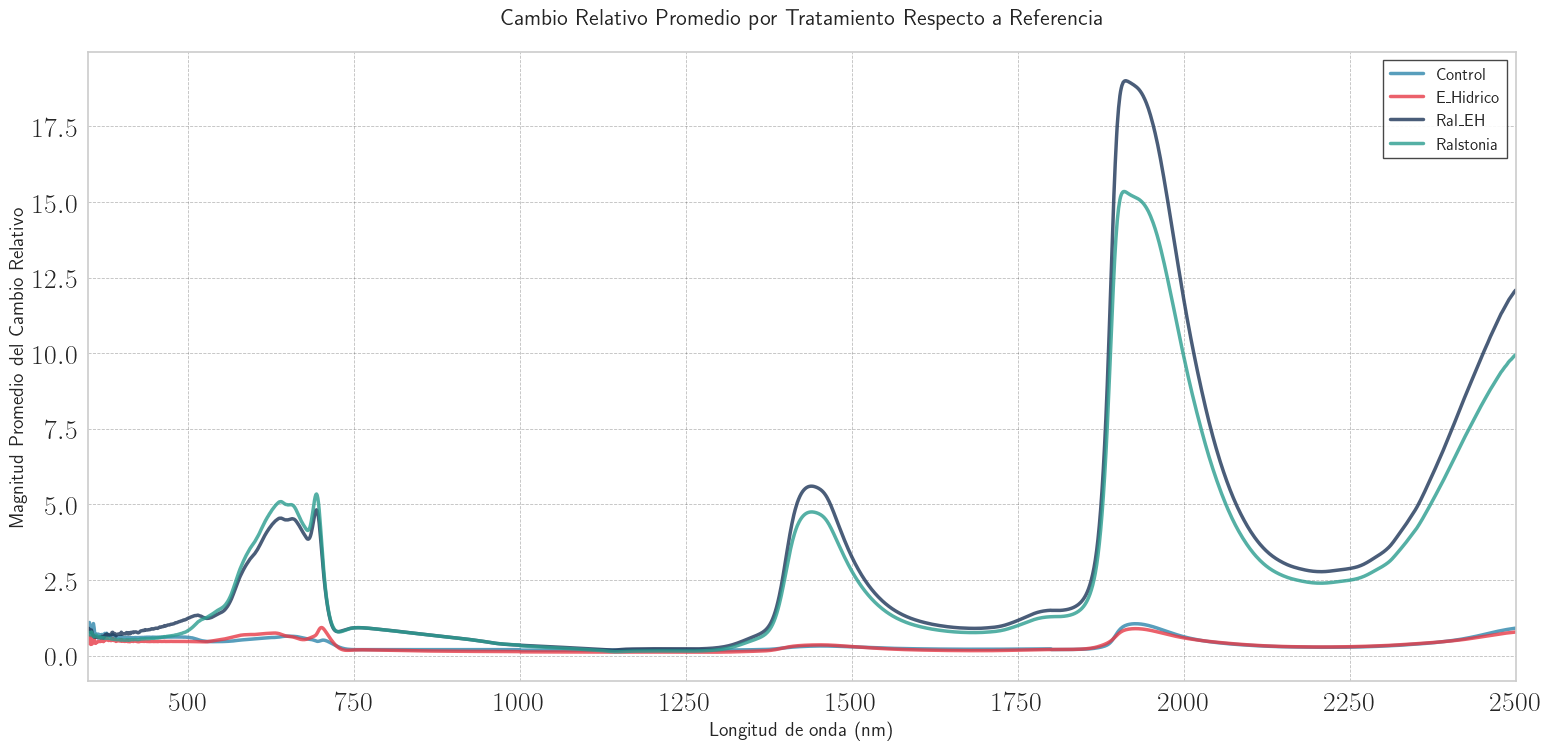

In [7]:
# Get the wavelengths (column names) and convert to float
wavelengths = df_means.iloc[:, 1:].columns.astype(float)

# Create the plot
plt.figure(figsize=(16, 8))

# Define colors for each treatment
colors = {
    'Control': '#2E86AB',
    'Tratamiento 1': '#A23B72',
    'Tratamiento 2': '#F18F01',
    'Tratamiento 3': '#6A994E',
    'Tratamiento 4': '#C73E1D'
}

# Plot each treatment
for treatment in df_means.index:
    magnitudes = df_means.loc[treatment].iloc[1:].values
    
    # Use predefined color if available, otherwise use default
    color = colors.get(treatment, None)
    
    plt.plot(wavelengths, magnitudes, 
             label=treatment, 
             linewidth=2.5, 
             alpha=0.8,
             color=color,) 

plt.xlabel('Longitud de onda (nm)', fontsize=14, fontweight='bold')
plt.ylabel('Magnitud Promedio del Cambio Relativo', fontsize=14, fontweight='bold')
plt.title('Cambio Relativo Promedio por Tratamiento Respecto a Referencia', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(wavelengths.min(), wavelengths.max())
plt.tight_layout()
plt.show()

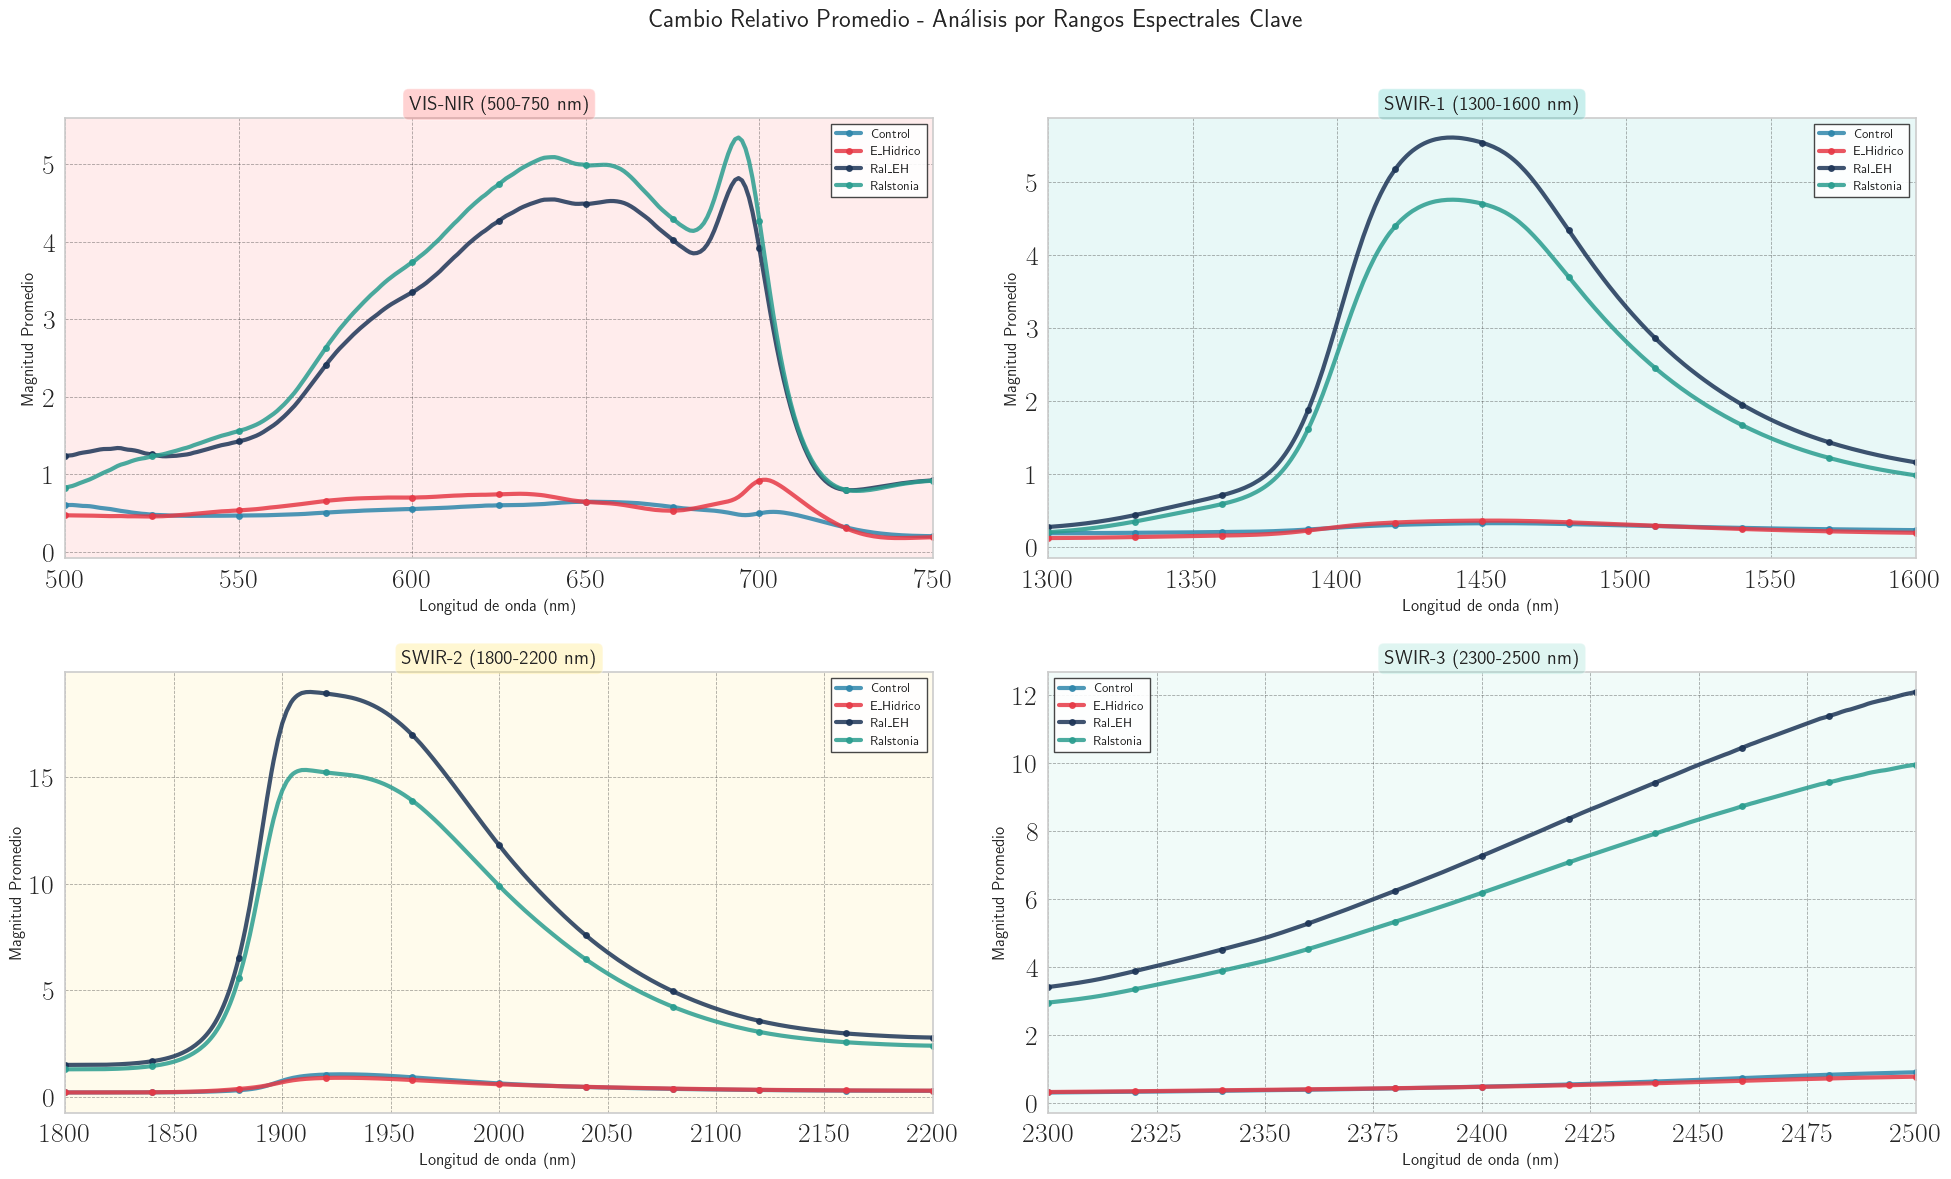

In [8]:
# Get the wavelengths (column names) and convert to float
wavelengths = df_means.iloc[:, 1:].columns.astype(float)

# Create subplots - one for each important range
fig = plt.figure(figsize=(20, 12))

# Define the important wavelength ranges
important_ranges = [
    (500, 750, '#FF6B6B', 'VIS-NIR (500-750 nm)'),
    (1300, 1600, '#4ECDC4', 'SWIR-1 (1300-1600 nm)'),
    (1800, 2200, '#FFE66D', 'SWIR-2 (1800-2200 nm)'),
    (2300, 2500, '#95E1D3', 'SWIR-3 (2300-2500 nm)')
]

# Define colors for each treatment
treatment_colors = {
    'Control': '#2E86AB',
    'Tratamiento 1': '#A23B72',
    'Tratamiento 2': '#F18F01',
    'Tratamiento 3': '#6A994E',
    'Tratamiento 4': '#C73E1D'
}

# Create 4 subplots for each range
for idx, (start, end, color, label) in enumerate(important_ranges, 1):
    ax = plt.subplot(2, 2, idx)
    
    # Filter wavelengths in this range
    mask = (wavelengths >= start) & (wavelengths <= end)
    range_wavelengths = wavelengths[mask]
    
    # Plot each treatment in this range
    for treatment in df_means.index:
        magnitudes = df_means.loc[treatment].iloc[1:].values
        range_magnitudes = magnitudes[mask]
        
        ax.plot(range_wavelengths, range_magnitudes,
                label=treatment,
                linewidth=3,
                alpha=0.85,
                color=treatment_colors.get(treatment),
                marker='o',
                markersize=4,
                markevery=max(1, len(range_wavelengths)//10))
    
    # Highlight the background
    ax.set_facecolor(color + '20')  # Add transparency
    
    ax.set_xlabel('Longitud de onda (nm)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Magnitud Promedio', fontsize=12, fontweight='bold')
    ax.set_title(label, fontsize=14, fontweight='bold', 
                 bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    ax.legend(fontsize=9, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.set_xlim(start, end)

plt.suptitle('Cambio Relativo Promedio - Análisis por Rangos Espectrales Clave', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()